Epoch [1/100] - Train Loss: 12.9474, Val Loss: 10.8571
✅ Checkpoint saved at epoch 1 with val_loss: 10.8571
Epoch [2/100] - Train Loss: 9.4246, Val Loss: 7.9369
✅ Checkpoint saved at epoch 2 with val_loss: 7.9369
Epoch [3/100] - Train Loss: 7.4412, Val Loss: 5.9721
✅ Checkpoint saved at epoch 3 with val_loss: 5.9721
Epoch [4/100] - Train Loss: 5.5346, Val Loss: 5.0927
✅ Checkpoint saved at epoch 4 with val_loss: 5.0927
Epoch [5/100] - Train Loss: 6.0001, Val Loss: 6.1052
Epoch [6/100] - Train Loss: 6.1548, Val Loss: 5.9794
Epoch [7/100] - Train Loss: 5.8957, Val Loss: 5.9636
Epoch [8/100] - Train Loss: 5.7071, Val Loss: 6.6913
Epoch [9/100] - Train Loss: 5.7092, Val Loss: 5.8176
Epoch [10/100] - Train Loss: 5.5539, Val Loss: 5.8830
Epoch [11/100] - Train Loss: 5.5963, Val Loss: 5.2878
Epoch [12/100] - Train Loss: 5.3488, Val Loss: 5.5058
Epoch [13/100] - Train Loss: 5.1560, Val Loss: 5.3652
Epoch [14/100] - Train Loss: 5.2476, Val Loss: 5.5202
Epoch [15/100] - Train Loss: 5.3255, Val L

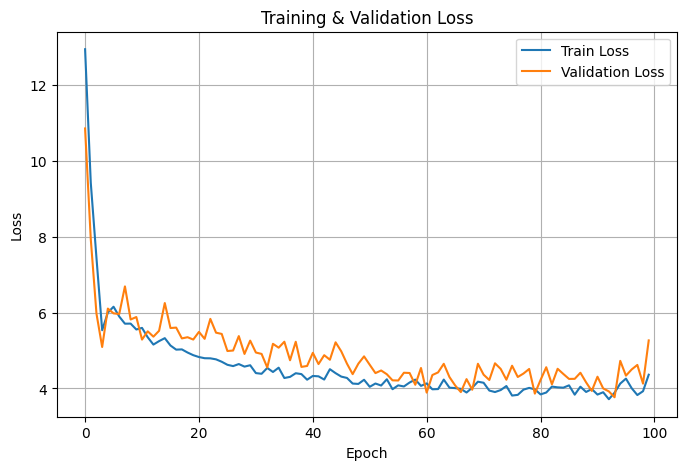

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ModelCheckpoint Callback
class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def __call__(self, current, epoch, model, optimizer):
        is_better = (current < self.best) if self.mode == 'min' else (current > self.best)
        if self.save_best_only and not is_better:
            return
        self.best = current
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            self.monitor: current
        }
        torch.save(checkpoint, self.filepath)
        print(f"✅ Checkpoint saved at epoch {epoch+1} with {self.monitor}: {current:.4f}")

# ArcFace + Attention Model
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = torch.cos(torch.tensor(m))
        self.sin_m = torch.sin(torch.tensor(m))
        self.th = torch.cos(torch.tensor(torch.pi) - m)
        self.mm = torch.sin(torch.tensor(torch.pi) - m) * m

    def forward(self, input, label):
        cosine = nn.functional.linear(nn.functional.normalize(input), nn.functional.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x1, x2):
        B, C, H, W = x1.shape
        x1 = x1.flatten(2).permute(0, 2, 1)
        x2 = x2.flatten(2).permute(0, 2, 1)

        qkv1 = self.qkv(x1).chunk(3, dim=-1)
        qkv2 = self.qkv(x2).chunk(3, dim=-1)

        q, k, v = qkv1[0], qkv2[1], qkv2[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = attn @ v
        out = self.proj(out)
        out = out.permute(0, 2, 1).reshape(B, C, H, W)
        return out

class ChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttention, self).__init__()
        self.cross_attention = CrossAttention(in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        ca_out = self.cross_attention(x, x)
        return self.sigmoid(ca_out) * x

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.cross_attention = CrossAttention(in_channels)
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        sa_out = self.cross_attention(x, x)
        sa_out = self.conv(sa_out)
        return self.sigmoid(sa_out) * x

class CA_CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CA_CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention(in_channels)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(FaceRecognitionModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            CA_CBAM(128),
            nn.AdaptiveAvgPool2d(1)
        )
        self.embedding = nn.Linear(128, 128)
        self.arc_margin = ArcMarginProduct(128, num_classes)

    def forward(self, x, label=None):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        if label is not None:
            return self.arc_margin(x, label)
        return x

# Data Loading
data_dir = r"D:\Projects\Sentinel turret rover\Data\4Class_Data_split2"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = FaceRecognitionModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

train_losses, val_losses = [], []

# Keras-style checkpoint
best_model_path = r"D:\Projects\Sentinel turret rover\model\best_model_checkpoint2.pth"
checkpoint_cb = ModelCheckpoint(filepath=best_model_path, monitor='val_loss', save_best_only=True, mode='min')

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, labels)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model using checkpoint callback
    checkpoint_cb(val_loss, epoch, model, optimizer)

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch [1/100] - Train Loss: 12.5875, Val Loss: 12.4420 | Train Acc: 30.92%, Val Acc: 27.50%
✅ Checkpoint saved at epoch 1 with val_loss: 12.4420
Epoch [2/100] - Train Loss: 9.3093, Val Loss: 8.2378 | Train Acc: 63.08%, Val Acc: 58.75%
✅ Checkpoint saved at epoch 2 with val_loss: 8.2378
Epoch [3/100] - Train Loss: 7.2555, Val Loss: 5.8686 | Train Acc: 64.17%, Val Acc: 61.25%
✅ Checkpoint saved at epoch 3 with val_loss: 5.8686
Epoch [4/100] - Train Loss: 5.5997, Val Loss: 5.5154 | Train Acc: 63.75%, Val Acc: 71.25%
✅ Checkpoint saved at epoch 4 with val_loss: 5.5154
Epoch [5/100] - Train Loss: 6.3531, Val Loss: 6.2257 | Train Acc: 62.92%, Val Acc: 70.00%
Epoch [6/100] - Train Loss: 6.1061, Val Loss: 5.7460 | Train Acc: 71.58%, Val Acc: 71.25%
Epoch [7/100] - Train Loss: 5.9435, Val Loss: 6.0754 | Train Acc: 77.00%, Val Acc: 72.50%
Epoch [8/100] - Train Loss: 5.8700, Val Loss: 5.5188 | Train Acc: 74.92%, Val Acc: 72.50%
Epoch [9/100] - Train Loss: 5.6309, Val Loss: 5.9169 | Train Acc: 71.

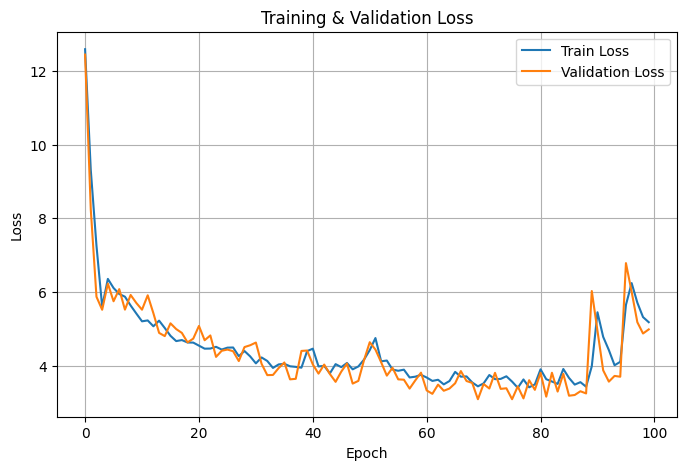

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ModelCheckpoint Callback
class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def __call__(self, current, epoch, model, optimizer):
        is_better = (current < self.best) if self.mode == 'min' else (current > self.best)
        if self.save_best_only and not is_better:
            return
        self.best = current
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            self.monitor: current
        }
        torch.save(checkpoint, self.filepath)
        print(f"✅ Checkpoint saved at epoch {epoch+1} with {self.monitor}: {current:.4f}")

# ArcFace + Attention Model
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = torch.cos(torch.tensor(m))
        self.sin_m = torch.sin(torch.tensor(m))
        self.th = torch.cos(torch.tensor(torch.pi) - m)
        self.mm = torch.sin(torch.tensor(torch.pi) - m) * m

    def forward(self, input, label):
        cosine = nn.functional.linear(nn.functional.normalize(input), nn.functional.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x1, x2):
        B, C, H, W = x1.shape
        x1 = x1.flatten(2).permute(0, 2, 1)
        x2 = x2.flatten(2).permute(0, 2, 1)

        qkv1 = self.qkv(x1).chunk(3, dim=-1)
        qkv2 = self.qkv(x2).chunk(3, dim=-1)

        q, k, v = qkv1[0], qkv2[1], qkv2[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = attn @ v
        out = self.proj(out)
        out = out.permute(0, 2, 1).reshape(B, C, H, W)
        return out

class ChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttention, self).__init__()
        self.cross_attention = CrossAttention(in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        ca_out = self.cross_attention(x, x)
        return self.sigmoid(ca_out) * x

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.cross_attention = CrossAttention(in_channels)
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        sa_out = self.cross_attention(x, x)
        sa_out = self.conv(sa_out)
        return self.sigmoid(sa_out) * x

class CA_CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CA_CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention(in_channels)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(FaceRecognitionModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            CA_CBAM(128),
            nn.AdaptiveAvgPool2d(1)
        )
        self.embedding = nn.Linear(128, 128)
        self.arc_margin = ArcMarginProduct(128, num_classes)

    def forward(self, x, label=None):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        if label is not None:
            return self.arc_margin(x, label)
        return x

# Accuracy Calculation
def calculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            cos_sim = nn.functional.linear(
                nn.functional.normalize(embeddings),
                nn.functional.normalize(model.arc_margin.weight)
            )
            preds = torch.argmax(cos_sim, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Data Loading
data_dir = r"D:\Projects\Sentinel turret rover\Data\4Class_Data_split2"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = FaceRecognitionModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

train_losses, val_losses = [], []

best_model_path = r"D:\Projects\Sentinel turret rover\model\best_model.pth"
checkpoint_cb = ModelCheckpoint(filepath=best_model_path, monitor='val_loss', save_best_only=True, mode='min')

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, labels)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Accuracy calculation
    train_acc = calculate_accuracy(model, train_loader, device)
    val_acc = calculate_accuracy(model, val_loader, device)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

    checkpoint_cb(val_loss, epoch, model, optimizer)

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
